# Analysis using raw functions (not the MNE package)


## imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functional import seq
from scipy import signal
from itertools import combinations 

%matplotlib inline

## helper functions

### computation

In [3]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.
    Source: https://raphaelvallat.com/bandpower.html

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper
    

    band = np.asarray(band)
    low, high = band
    
    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        if data.shape[0] < nperseg:
            return np.NaN
            
        
        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
        
    return bp

In [189]:
def get_bandpower_for_electrode(signal_data, electrode, config, window_size='1s'):
    """Calculates the bandpower for the given electrode
    
    Note that this will take some time... I suggest that you only use a part of the signal to try it out.
    
    Parameters
    ----------
    signal_data: 2d pandas dataframe
        raw signal data, indexed by a timedeltaindex (or any other time-based index)
    electrode: string
        name of the electrode of interest
    config: dict
        dict of config parameters
    window_size: string
        size of rolling window
        
    Returns
    -------
    a new pandas dataframe of the bandpowers, in addition all ration combinations are listed as well
    """
    bandpowers = {}

    for band_name, band_range in config['bands'].items():
        bandpowers[band_name] = signal_data.loc[:, electrode]\
            .rolling(window_size)\
            .apply(lambda xs: bandpower(xs, config['sampling_frequency'], band_range))

    # compute all different ratios
    for bn_l, bn_r in combinations(cfg['bands'].keys(), 2):
        bandpowers[f"{bn_l} / {bn_r}"] = bandpowers[bn_l] / bandpowers[bn_r]
        
    return bandpowers 

In [ ]:
def aggregate_bandpower(baseline, signal):
    aggregated_fns = ['mean', 'median', 'min', 'max']
    aggregated_power = pd.DataFrame(index=pd.MultiIndex.from_product([list(baseline.keys()), ['baseline', 'meditation']]),
                                    columns=aggregated_fns)

    for band, power in baseline.items():
        aggregated_power.loc[(band, "baseline"), :] = power.agg(aggregated_fns)


    for band, power in signal.items():
        aggregated_power.loc[(band, 'meditation'), :] = power.agg(aggregated_fns)


    return aggregated_power

### data loading

In [131]:
def load_signal_data(data_type, config, subject='sam', recording=0, remove_references=True):
    """loads the data and returns a pandas dataframe 
    
    Parameters
    ----------
    data_type : string
      type of the data, right now two options are valid: `baseline` or `meditation`
    subject: string
      name of the subject
    recording: int
      number of recording, if you have multiple of same type and subject
      
    Returns
    -------
    a pandas dataframe, timedeltaindexed of the raw signals
    """
    subject_paths = get_config_value(config, 'paths', 'subjects', subject)
    data = pd.read_pickle(f"{config['paths']['base']}/{subject_paths['prefix']}/offline/{get_config_value(subject_paths, 'recordings', data_type)[recording]}-raw.pcl")
    
    _t = data['timestamps'].reshape(-1)
    _t -= _t[0]

    signal = pd.DataFrame(data=data['signals'], 
                          index=pd.TimedeltaIndex(_t, unit='s'), 
                          columns=data['ch_names'])\
               .drop(columns=config['columns_to_remove'])
    
    return signal.loc[signal.index[config['default_signal_crop']], :]

### plots

In [139]:
def plot_bandpowers(bandpowers, electrode):
    fig, axs = plt.subplots(nrows=len(bandpowers), sharex=True, figsize=(25, 15))
    time_index = list(bandpowers.values())[0].index
    time_index_as_seconds = [t.total_seconds() for t in time_index]

    for i, (bn, bp) in enumerate(bandpowers.items()):
        axs[i].plot(bp.reset_index(drop=True))
        axs[i].set_ylabel(bn)

    axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: index_to_time(x, time_index)))
    fig.suptitle(f"Bandpower of {electrode}")
    
    return fig


def plot_raw_signal(signal_pd, sampling=10):
    """
    Parameters
    ----------
    signal_pd: 2d pandas dataframe
        long-format (a column for each electrode)
    sampling: int
        step size of data points used for plotting
    
    Returns
    -------
    a figure of the plot
    
    """
    
    fig, axs = plt.subplots(nrows=signal_pd.shape[1], figsize=(40, 1.4 * signal_pd.shape[1]), sharex=True)
    for channel_id, channel in enumerate(signal_pd.columns):
        d = signal_pd.loc[::sampling, channel]
        sns.lineplot(data=d.reset_index(drop=True), ax=axs[channel_id])
        axs[channel_id].set_ylabel(channel)

    axs[-1].set_xlabel('time [ms]')
    axs[-1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: index_to_time(x, d.index)))
    
    fig.suptitle("Raw signal recording")
    
    return fig

In [133]:
def index_to_time(x, time_index, step_size=1):
    """Helper function to add the axis labels"""
    if (x < 0 or x * step_size >= len(time_index)):
        return ''
    
    seconds = time_index[int(x*step_size)].total_seconds()
    return f"{int(seconds/60)}\' {seconds/60:.2f}\""

In [134]:
def get_config_value(config, *args):
    """Helper to get read the config"""
    return reduce(lambda cfg, val: cfg[val], args, config)

# main stuff

In [181]:
# This is the config. Add any value that you deem necessary. This should contain everything that belongs to the setup, the filtering pipeline, etc.

cfg = {
    'paths': {
        'base': '../../data/AlphaTheta',
        'subjects': {
            'sam': {
                'prefix': '/sam-AlphaTheta',
                'recordings': {
                    'baseline': [
                        '20200304-144100',
                        '20200304-144601'
                    ],
                    'meditation': [
                         '20200304-144933'   
                    ]
                }
            },
            'adelie': {
                'prefix': '/adelie-AlphaTheta',
                'recordings': {
                    'baseline': [
                        '20200304-151358',
                    ],
                    'meditation': [
                        '20200304-152058',
                    ]
                }
            }
        }
    },
    'columns_to_remove': [
        'TRIGGER', 'X1', 'X2', 'X3',
    ],
    'default_signal_crop': np.s_[3000:-3000], # this corresponds to ~1 second at the beginning and end, given by the sampling frequency
    'sampling_frequency': 300,
    'bands': {
        'gamma': [40, 100],
        'beta':  [12, 40],
        'alpha': [8, 12],
        'theta': [4, 8],
        'delta': [0.5, 4]
    }
}

In [144]:
meditation_pd = load_signal_data('meditation', config=cfg)
baseline_pd = load_signal_data('baseline', config=cfg)

In [182]:
baseline_adelie_pd = load_signal_data('baseline', subject='adelie', config=cfg)
meditation_adelie_pd = load_signal_data('meditation', subject='adelie', config=cfg)

In [118]:
electrode_of_interest = 'O2'

In [141]:
meditation_bandpower = get_bandpower_for_electrode(meditation_pd, electrode=electrode_of_interest, config=cfg)
baseline_bandpower   = get_bandpower_for_electrode(baseline_pd, electrode=electrode_of_interest, config=cfg)

In [183]:
bandpower_adelie = {
    'baseline': get_bandpower_for_electrode(baseline_adelie_pd, electrode=electrode_of_interest, config=cfg),
    'meditation': get_bandpower_for_electrode(meditation_adelie_pd, electrode=electrode_of_interest, config=cfg)
}

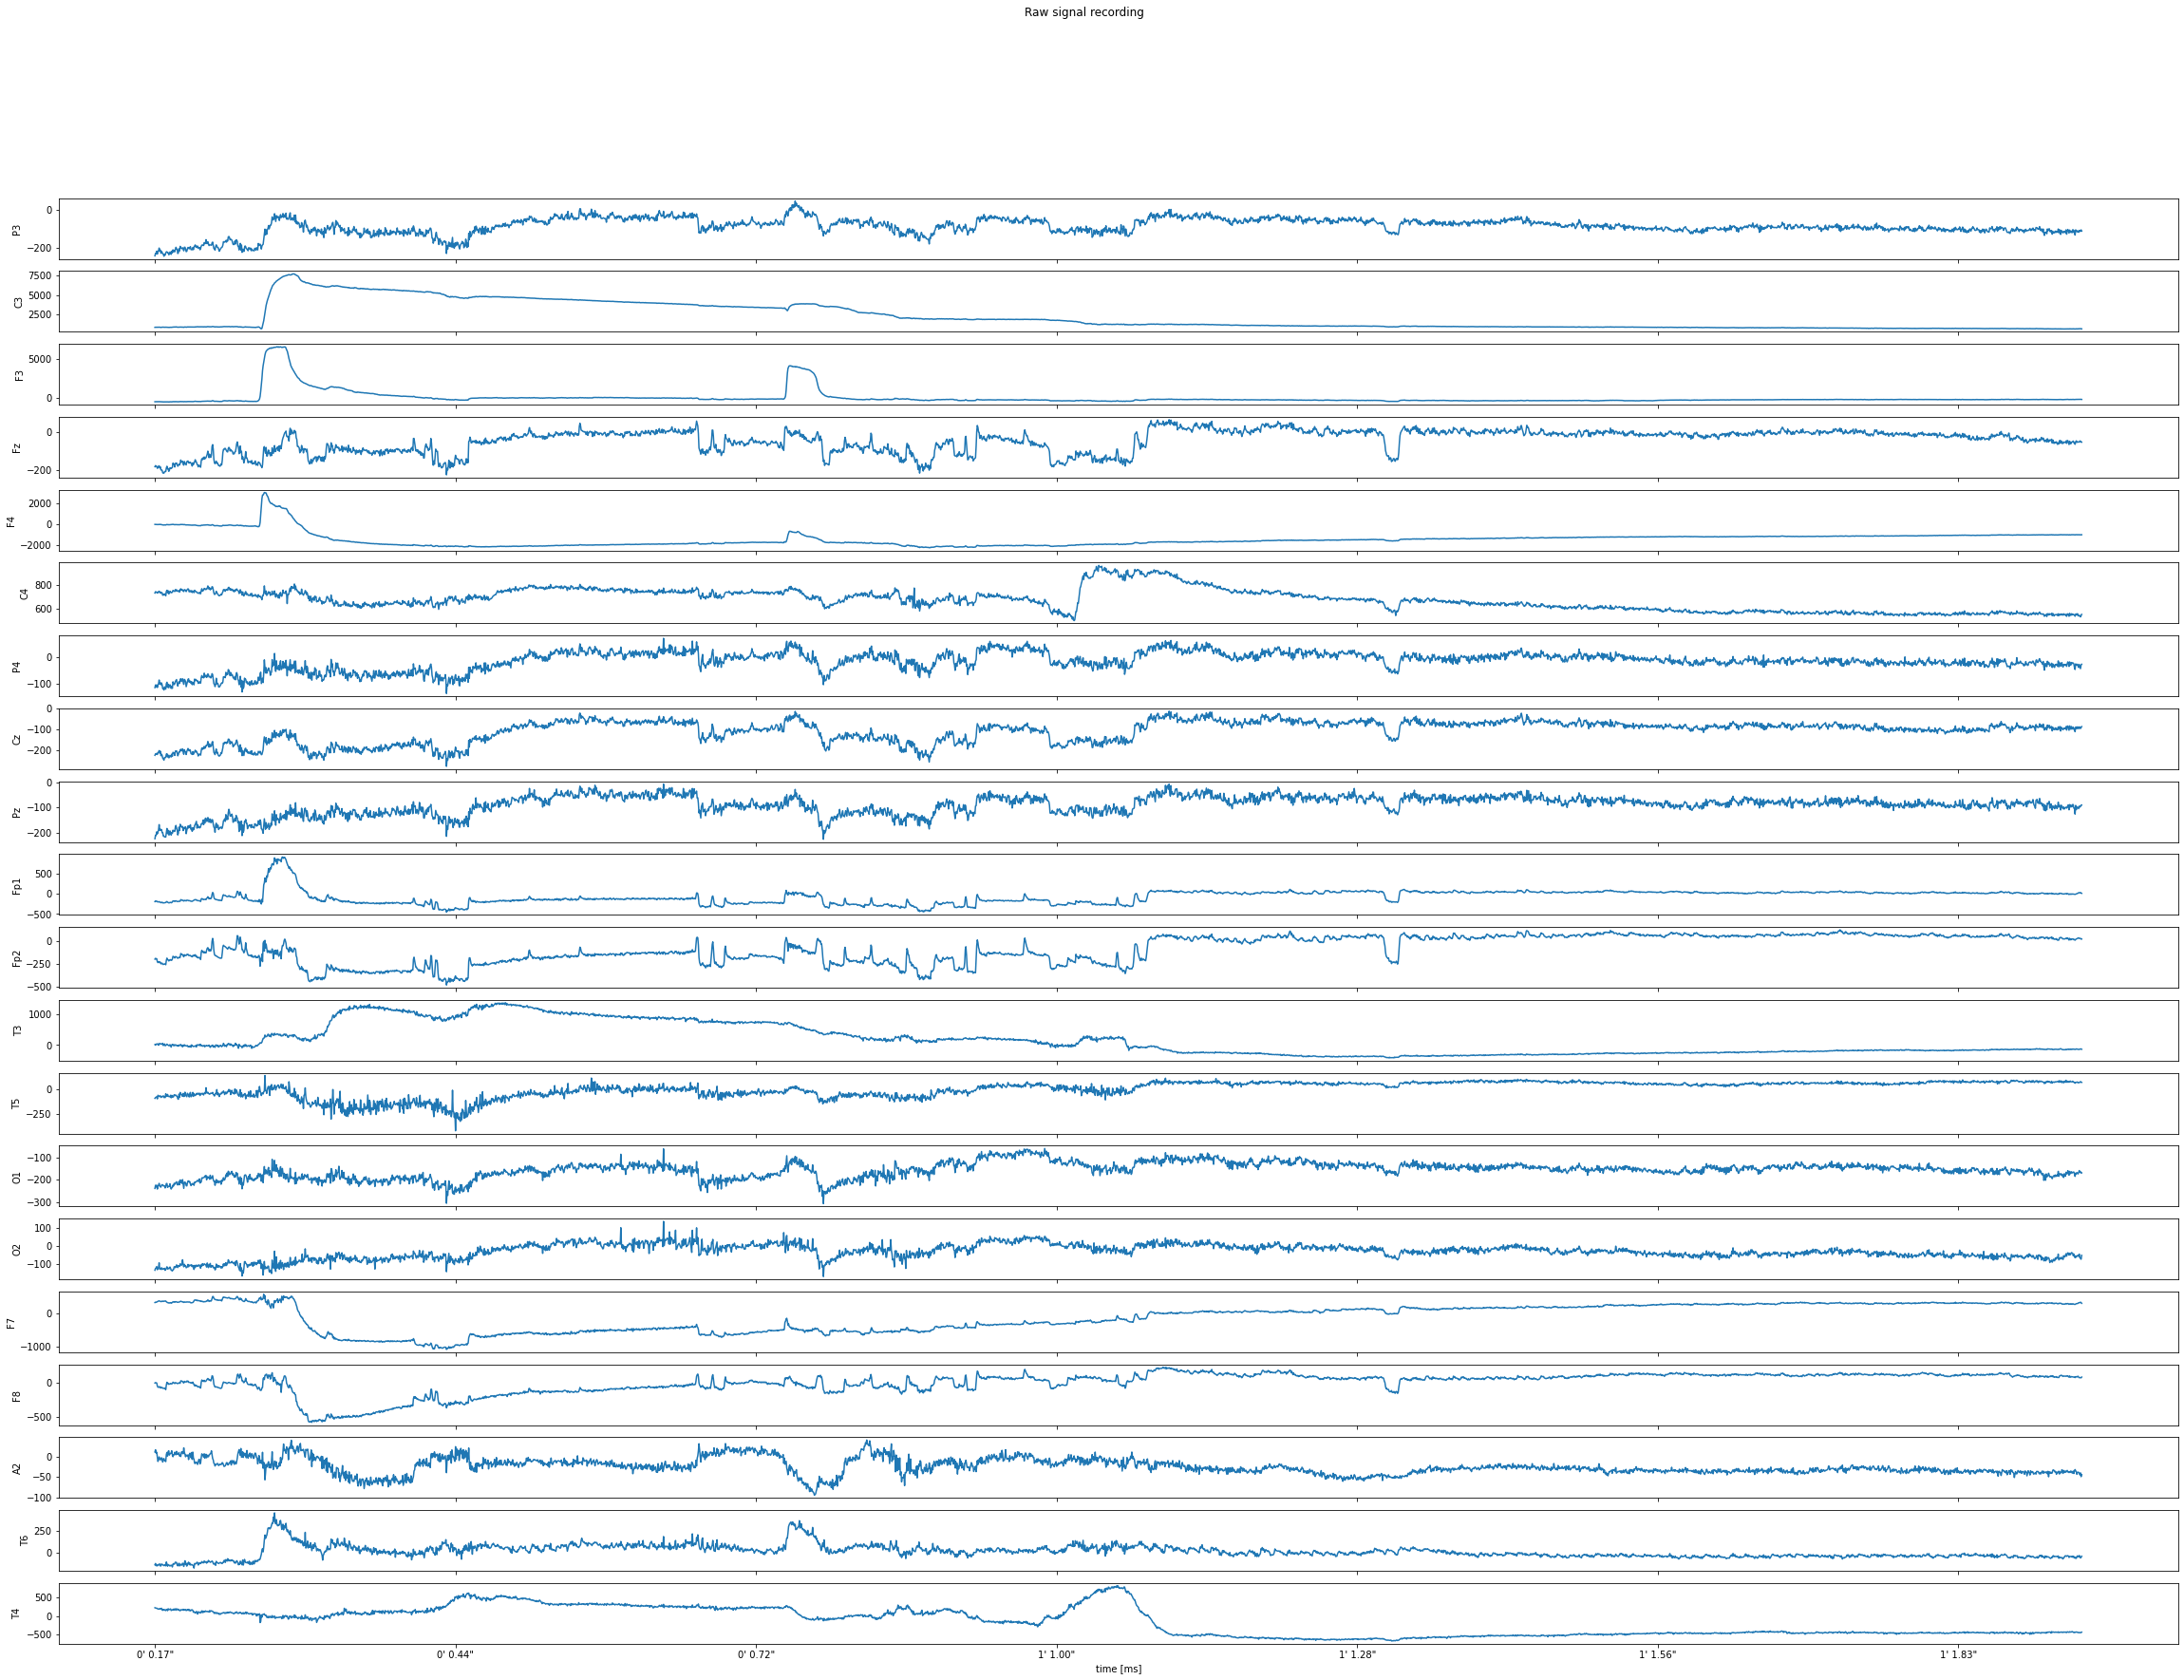

In [147]:
plot_raw_signal(baseline_pd);

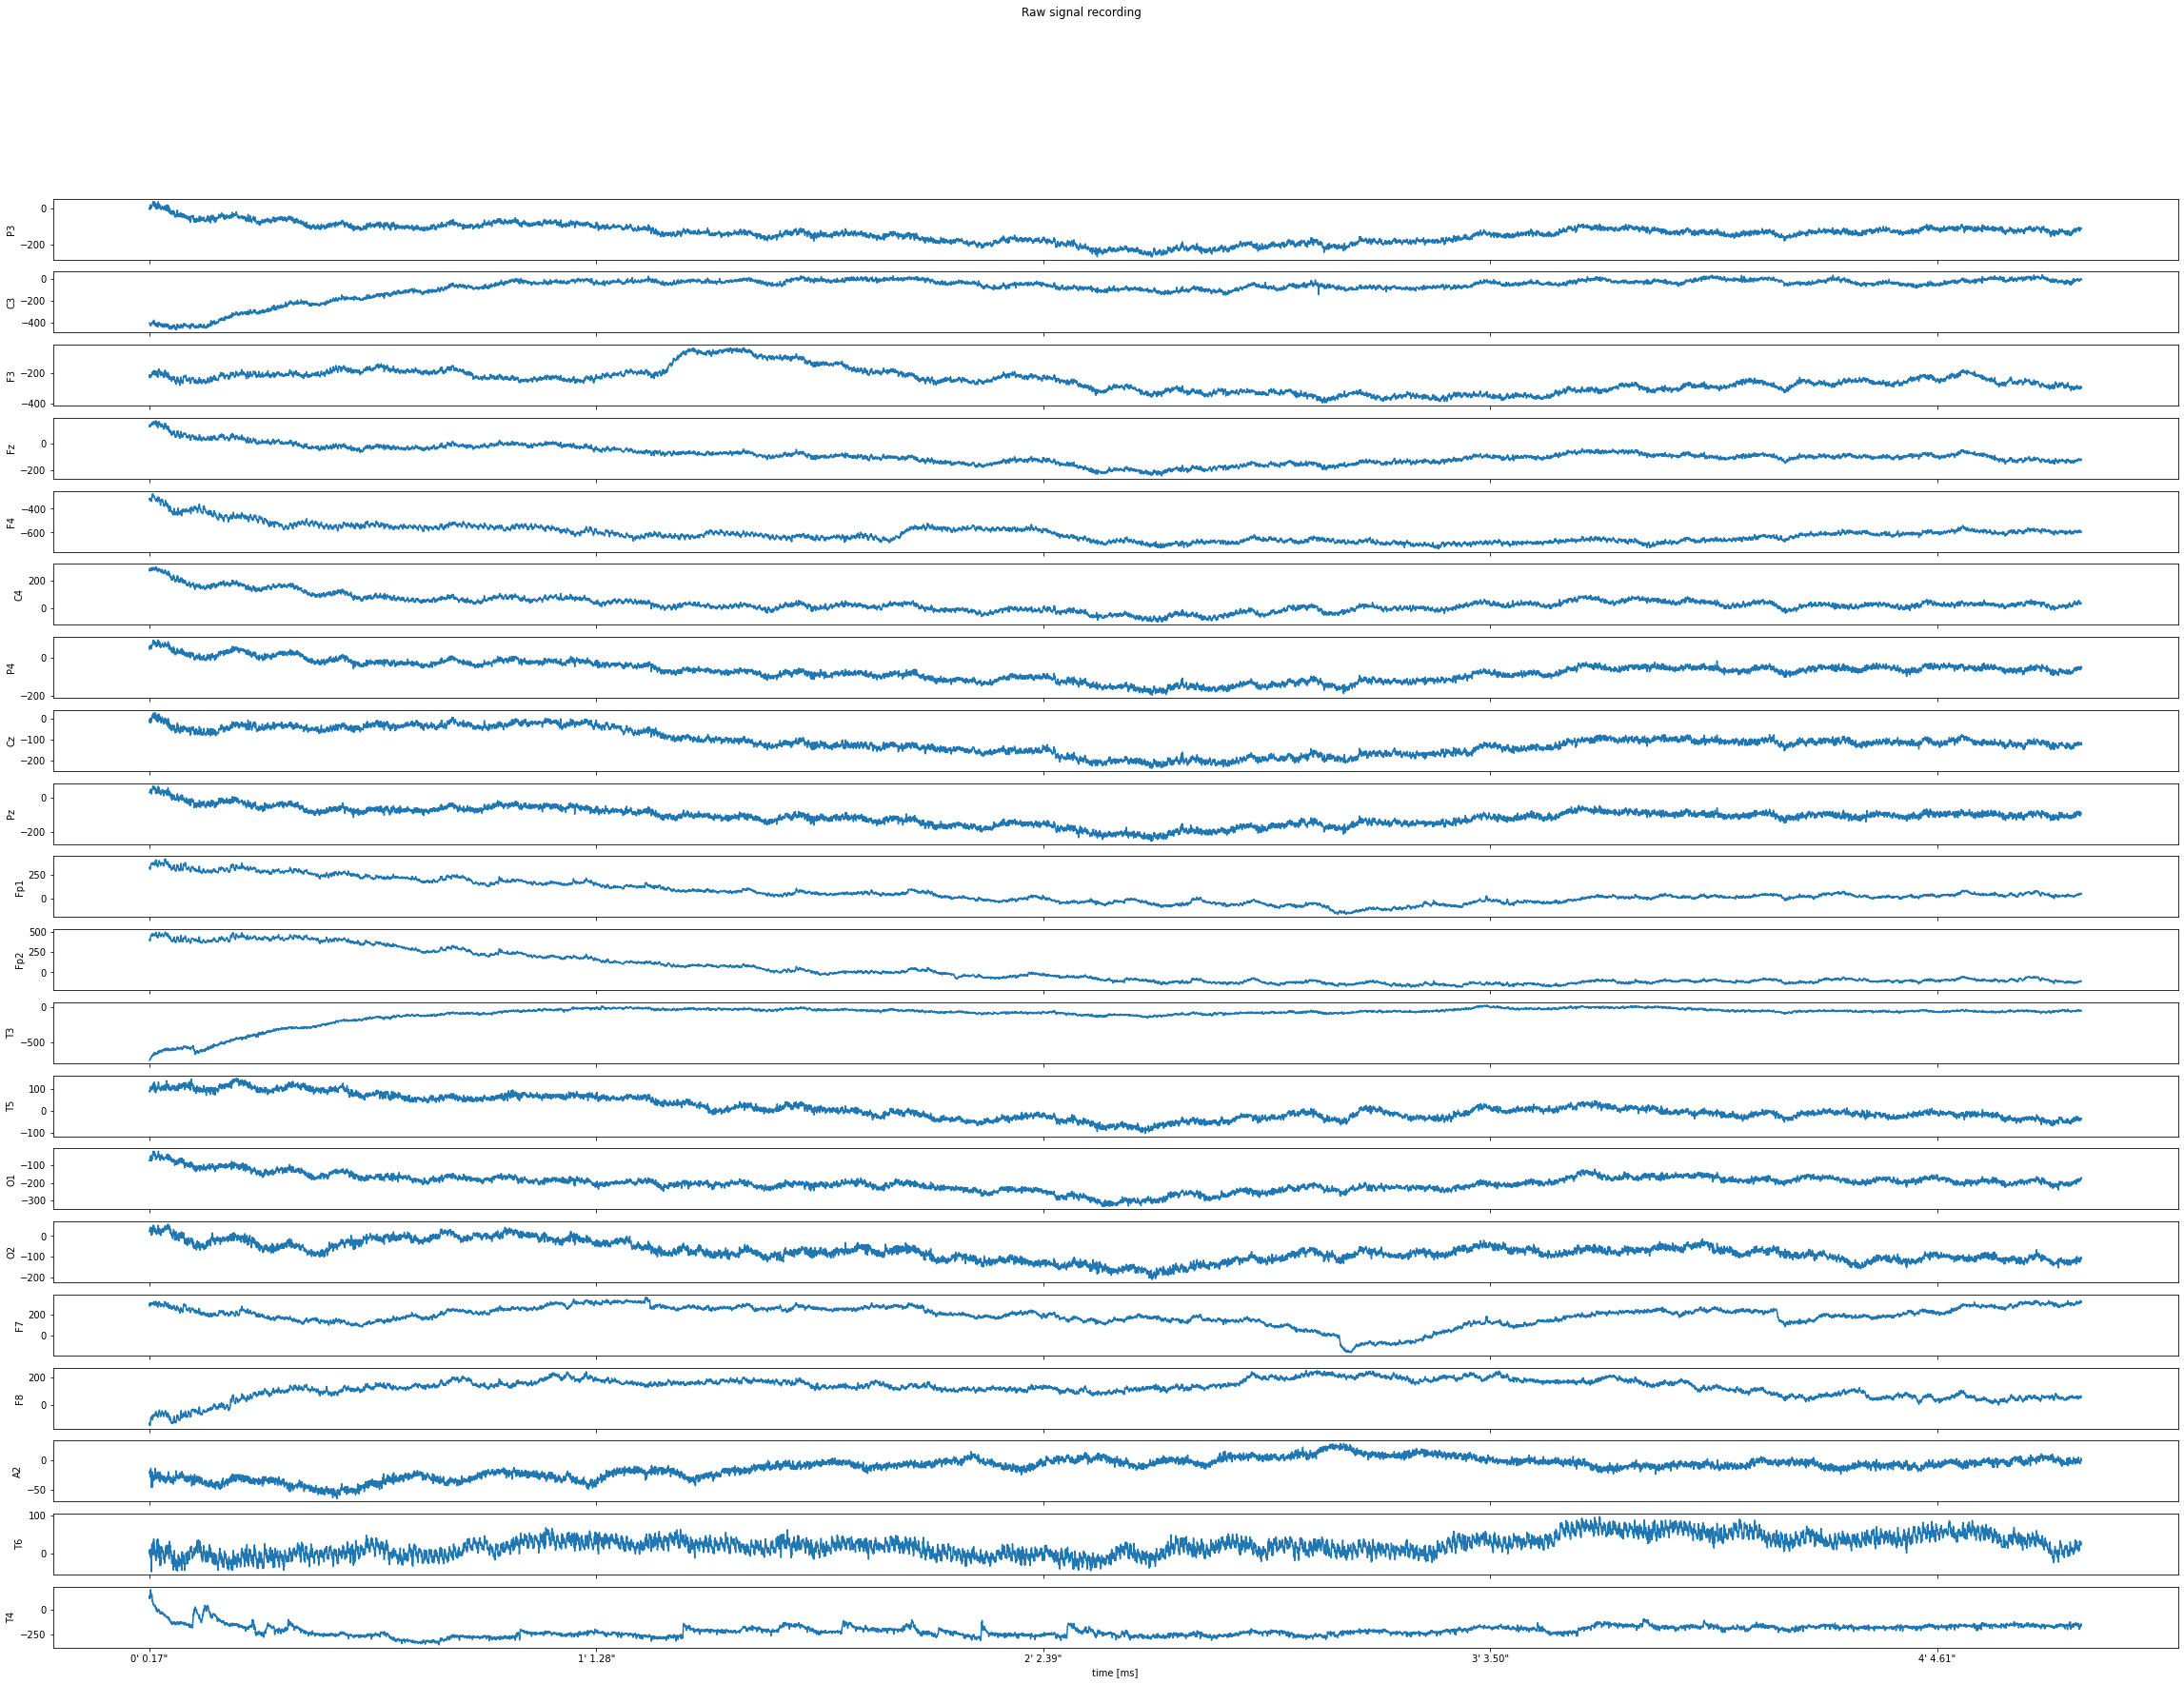

In [142]:
plot_raw_signal(meditation_pd);

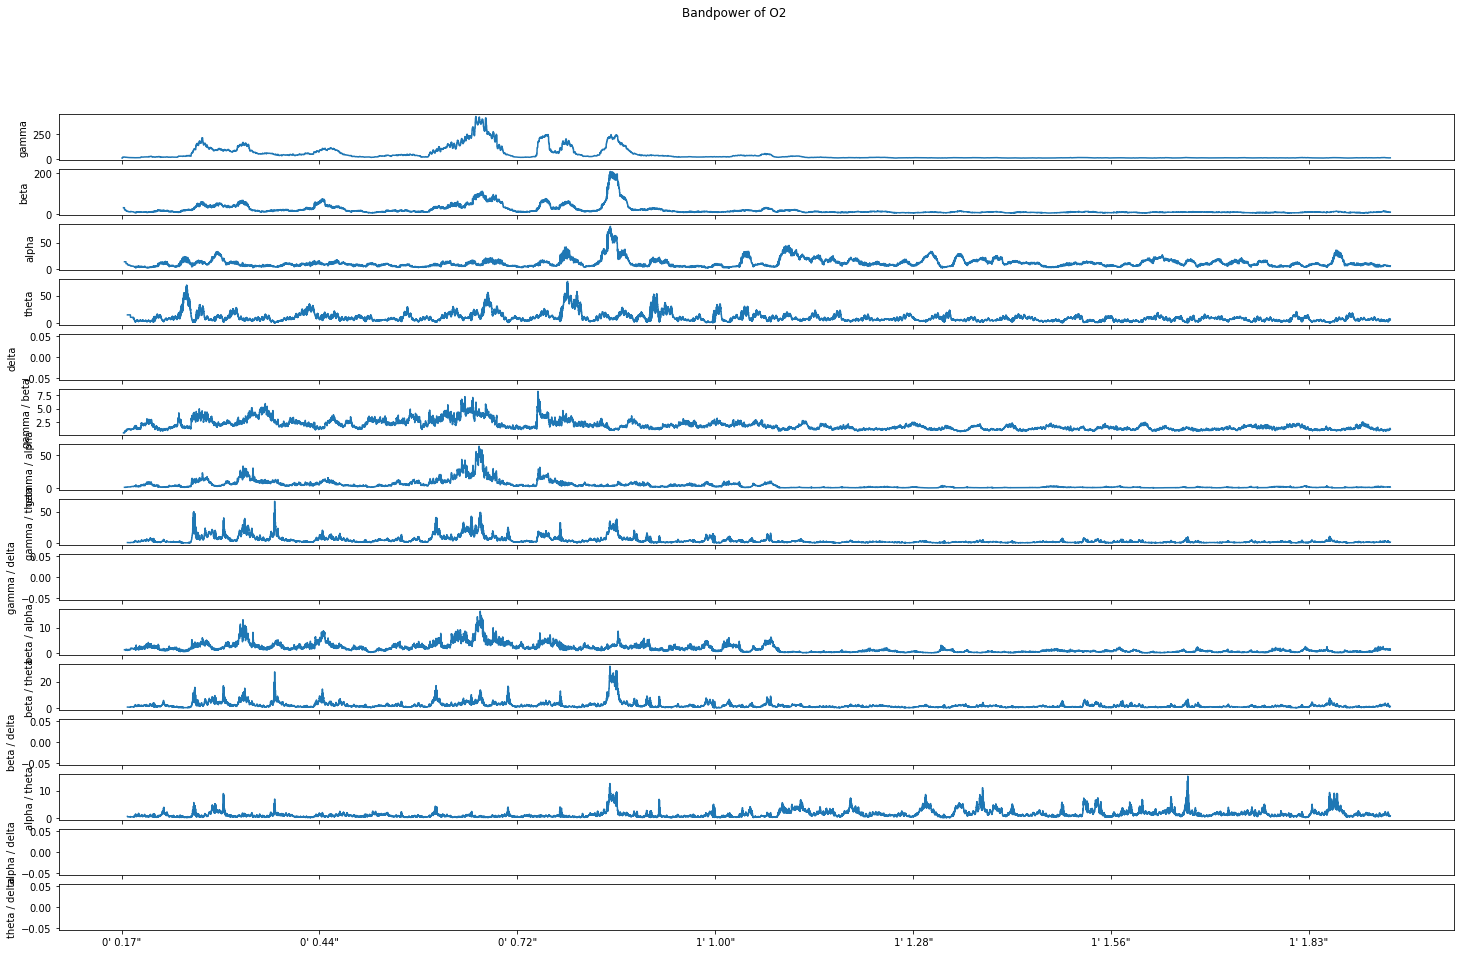

In [148]:
plot_bandpowers(baseline_bandpower, electrode=electrode_of_interest);

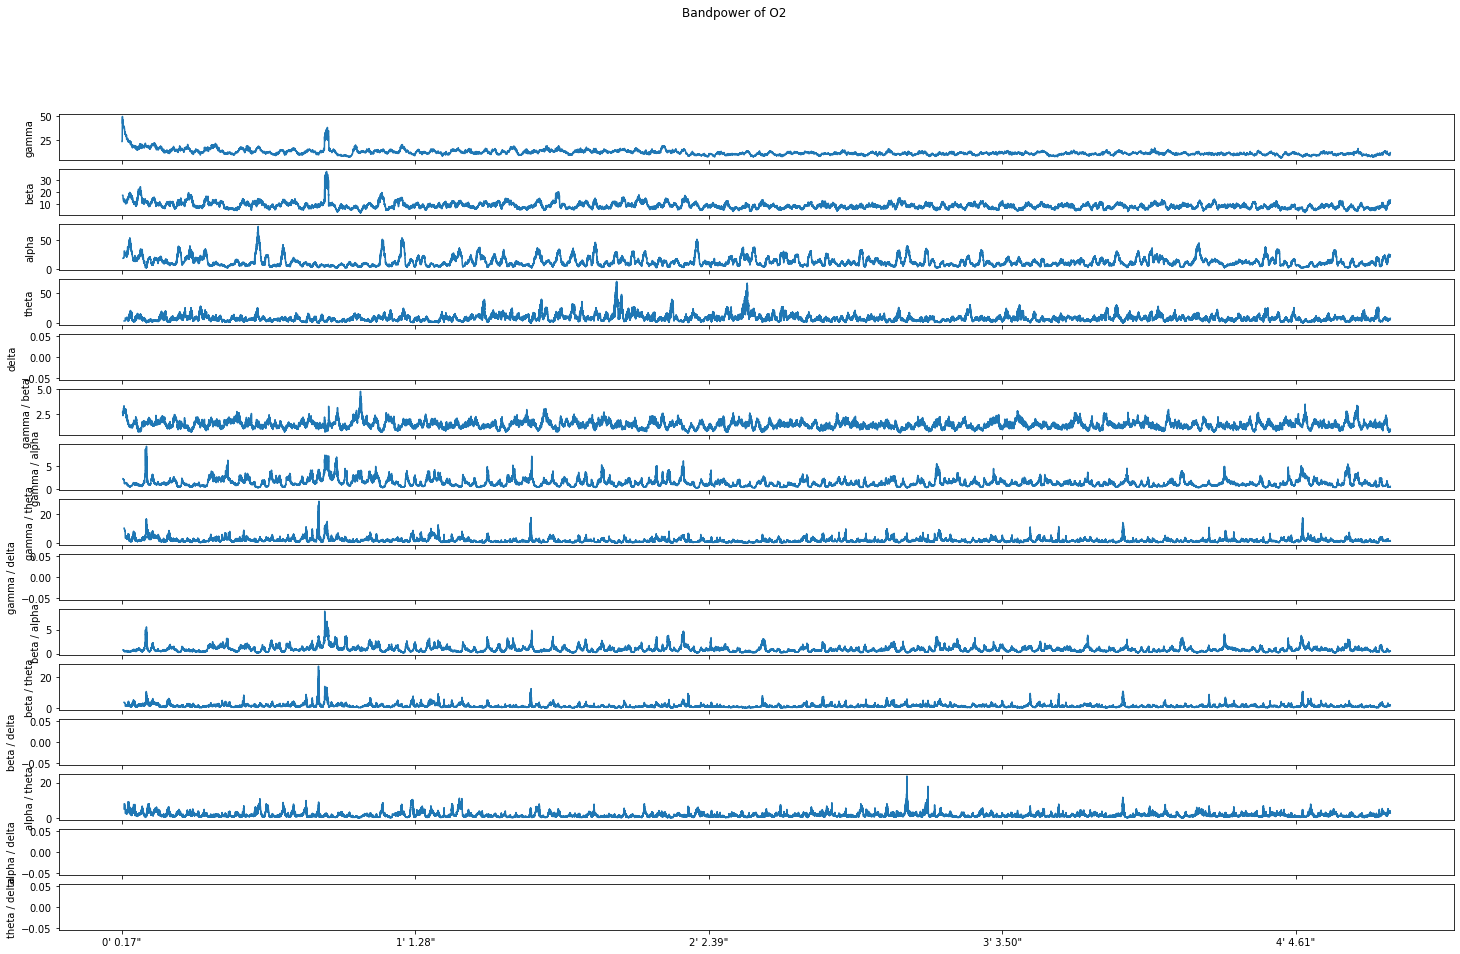

In [143]:
plot_bandpowers(meditation_bandpower, electrode=electrode_of_interest);

In [187]:
aggregated_power_adelie = aggregate_bandpower(baseline=bandpower_adelie['baseline'], signal=bandpower_adelie['meditation'])
aggregated_power_adelie

/home/sam/.local/opt/miniconda3/envs/eegmed/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


mean    median        min      max
gamma         baseline     8.58954   6.97805    3.89778  93.8201
              meditation   19.3257   13.5433     5.3791  157.453
beta          baseline     10.5799   10.0346    4.20081  34.9405
              meditation   14.3706   12.8754    3.72461  51.7035
alpha         baseline     41.2142   33.7936    6.02974  167.974
              meditation   30.9828   25.0233    1.86871  161.296
theta         baseline     20.3188   16.8603    1.67143   123.73
              meditation   15.7256   12.9646   0.759231  135.262
delta         baseline         NaN       NaN        NaN      NaN
              meditation       NaN       NaN        NaN      NaN
gamma / beta  baseline    0.802605   0.72379   0.337866   3.9874
              meditation   1.30234   1.20449   0.398453  5.26221
gamma / alpha baseline    0.299301  0.210973  0.0454615   5.2537
              meditation   1.11041  0.617611   0.068139  21.6358
gamma / theta baseline     0.59782  0.427338  0.0675693  5.76874
              meditation   1.88597   1.17597  0.0726064  42.6144
gamma / delta baseline         NaN       NaN        NaN      NaN
              meditation       NaN       NaN        NaN      NaN
beta / alpha  baseline     0.33902  0.282701  0.0556308  1.81598
              meditation  0.747944  0.506799  0.0854396   9.4694
beta / theta  baseline    0.714392  0.595351   0.101674  6.97054
              meditation   1.34025  0.990173  0.0412419  25.3022
beta / delta  baseline         NaN       NaN        NaN      NaN
              meditation       NaN       NaN        NaN      NaN
alpha / theta baseline     2.35703   2.11442    0.29637  23.7001
              meditation   2.25658   1.89397   0.190806  23.1068
alpha / delta baseline         NaN       NaN        NaN      NaN
              meditation       NaN       NaN        NaN      NaN
theta / delta baseline         NaN       NaN        NaN      NaN
              meditation       NaN       NaN        NaN      NaN

In [188]:
aggregated_power_sam = aggregate_bandpower(baseline=baseline_bandpower, signal=meditation_bandpower)
aggregated_power_sam

/home/sam/.local/opt/miniconda3/envs/eegmed/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


mean    median       min      max
gamma         baseline     42.2779   17.5026   7.19122  433.564
              meditation    12.411   11.8831   6.45542  49.8708
beta          baseline     18.7361   10.4697   3.64979  209.062
              meditation   8.80379    8.4133   2.54641   37.022
alpha         baseline     11.4665   9.35318   1.76369  80.8188
              meditation   12.6105   10.3341   1.67477  73.7322
theta         baseline     10.3528   8.48492  0.641602  75.4264
              meditation   8.69613   7.66359  0.377764  70.2673
delta         baseline         NaN       NaN       NaN      NaN
              meditation       NaN       NaN       NaN      NaN
gamma / beta  baseline     1.94891   1.72255  0.567478  8.12702
              meditation    1.4731   1.43011  0.638659  4.80657
gamma / alpha baseline     4.43148   2.23018  0.290579  62.6406
              meditation   1.34286   1.14183  0.195055  9.22719
gamma / theta baseline      4.2882    2.2882  0.406905   66.241
              meditation   1.93858   1.57374   0.18351  28.7274
gamma / delta baseline         NaN       NaN       NaN      NaN
              meditation       NaN       NaN       NaN      NaN
beta / alpha  baseline     1.89125   1.40002   0.22862  16.3944
              meditation  0.930387  0.797072  0.154098  8.82154
beta / theta  baseline     2.05177   1.44298  0.197355  31.6057
              meditation    1.3734   1.11792  0.126217  27.1075
beta / delta  baseline         NaN       NaN       NaN      NaN
              meditation       NaN       NaN       NaN      NaN
alpha / theta baseline     1.43216   1.05521  0.167441  15.2049
              meditation   1.72597    1.3901  0.196958  23.5801
alpha / delta baseline         NaN       NaN       NaN      NaN
              meditation       NaN       NaN       NaN      NaN
theta / delta baseline         NaN       NaN       NaN      NaN
              meditation       NaN       NaN       NaN      NaN

# Graveyard, not interesting below here

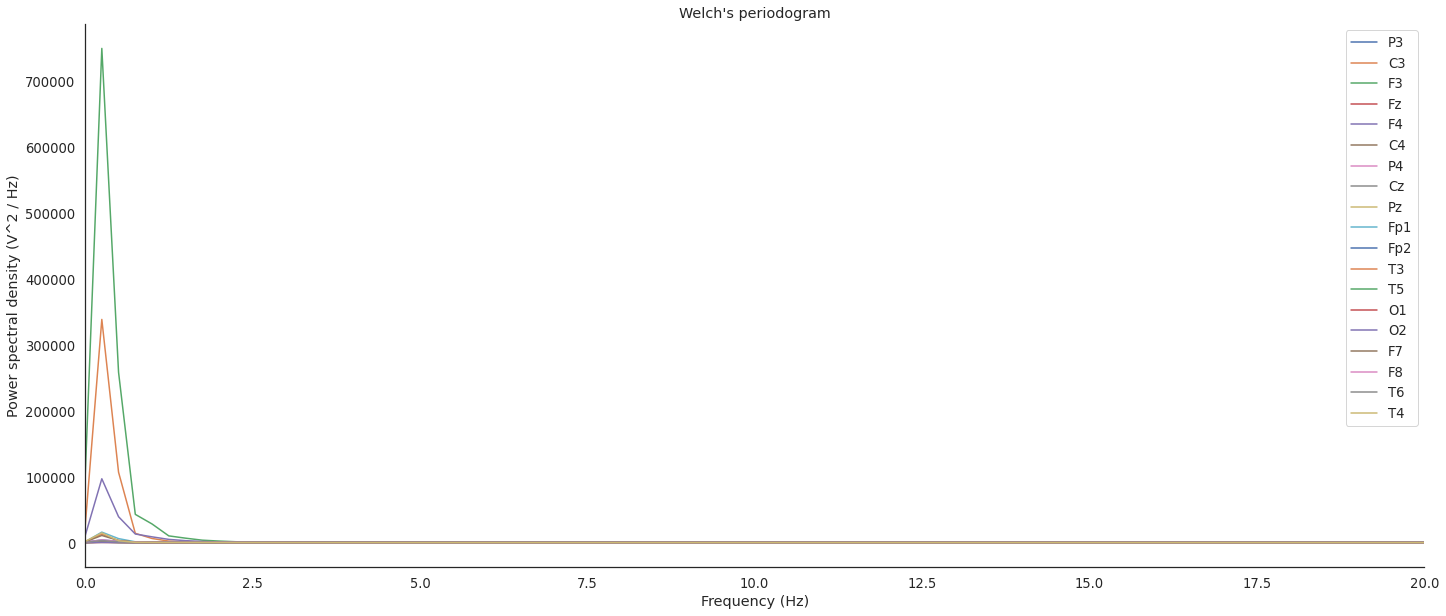

In [208]:
sampling_rate = 300
window_size = 4 * sampling_rate # in seconds

plt.figure(figsize=(24, 10))
for c in [c for c in signals_pd.columns if c not in ['TRIGGER', 'X1', 'X2', 'X3', 'A2']]:
    freqs, psd = signal.welch(signals_pd.loc[:, c], sampling_rate, nperseg=window_size)

    plt.plot(freqs, psd, label=c)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (V^2 / Hz)')
    #plt.ylim([0, psd.max() * 1.1])
    plt.title("Welch's periodogram")
    #plt.xlim([0, freqs.max()])
    plt.xlim([0, 20])
    sns.despine()
    
plt.legend();

In [213]:
# for a window size of... compute the power and compare it over time



bandpower(signals_pd.loc[:, 'T5'], 300., cfg['bands']['theta'])

7.676781094175913

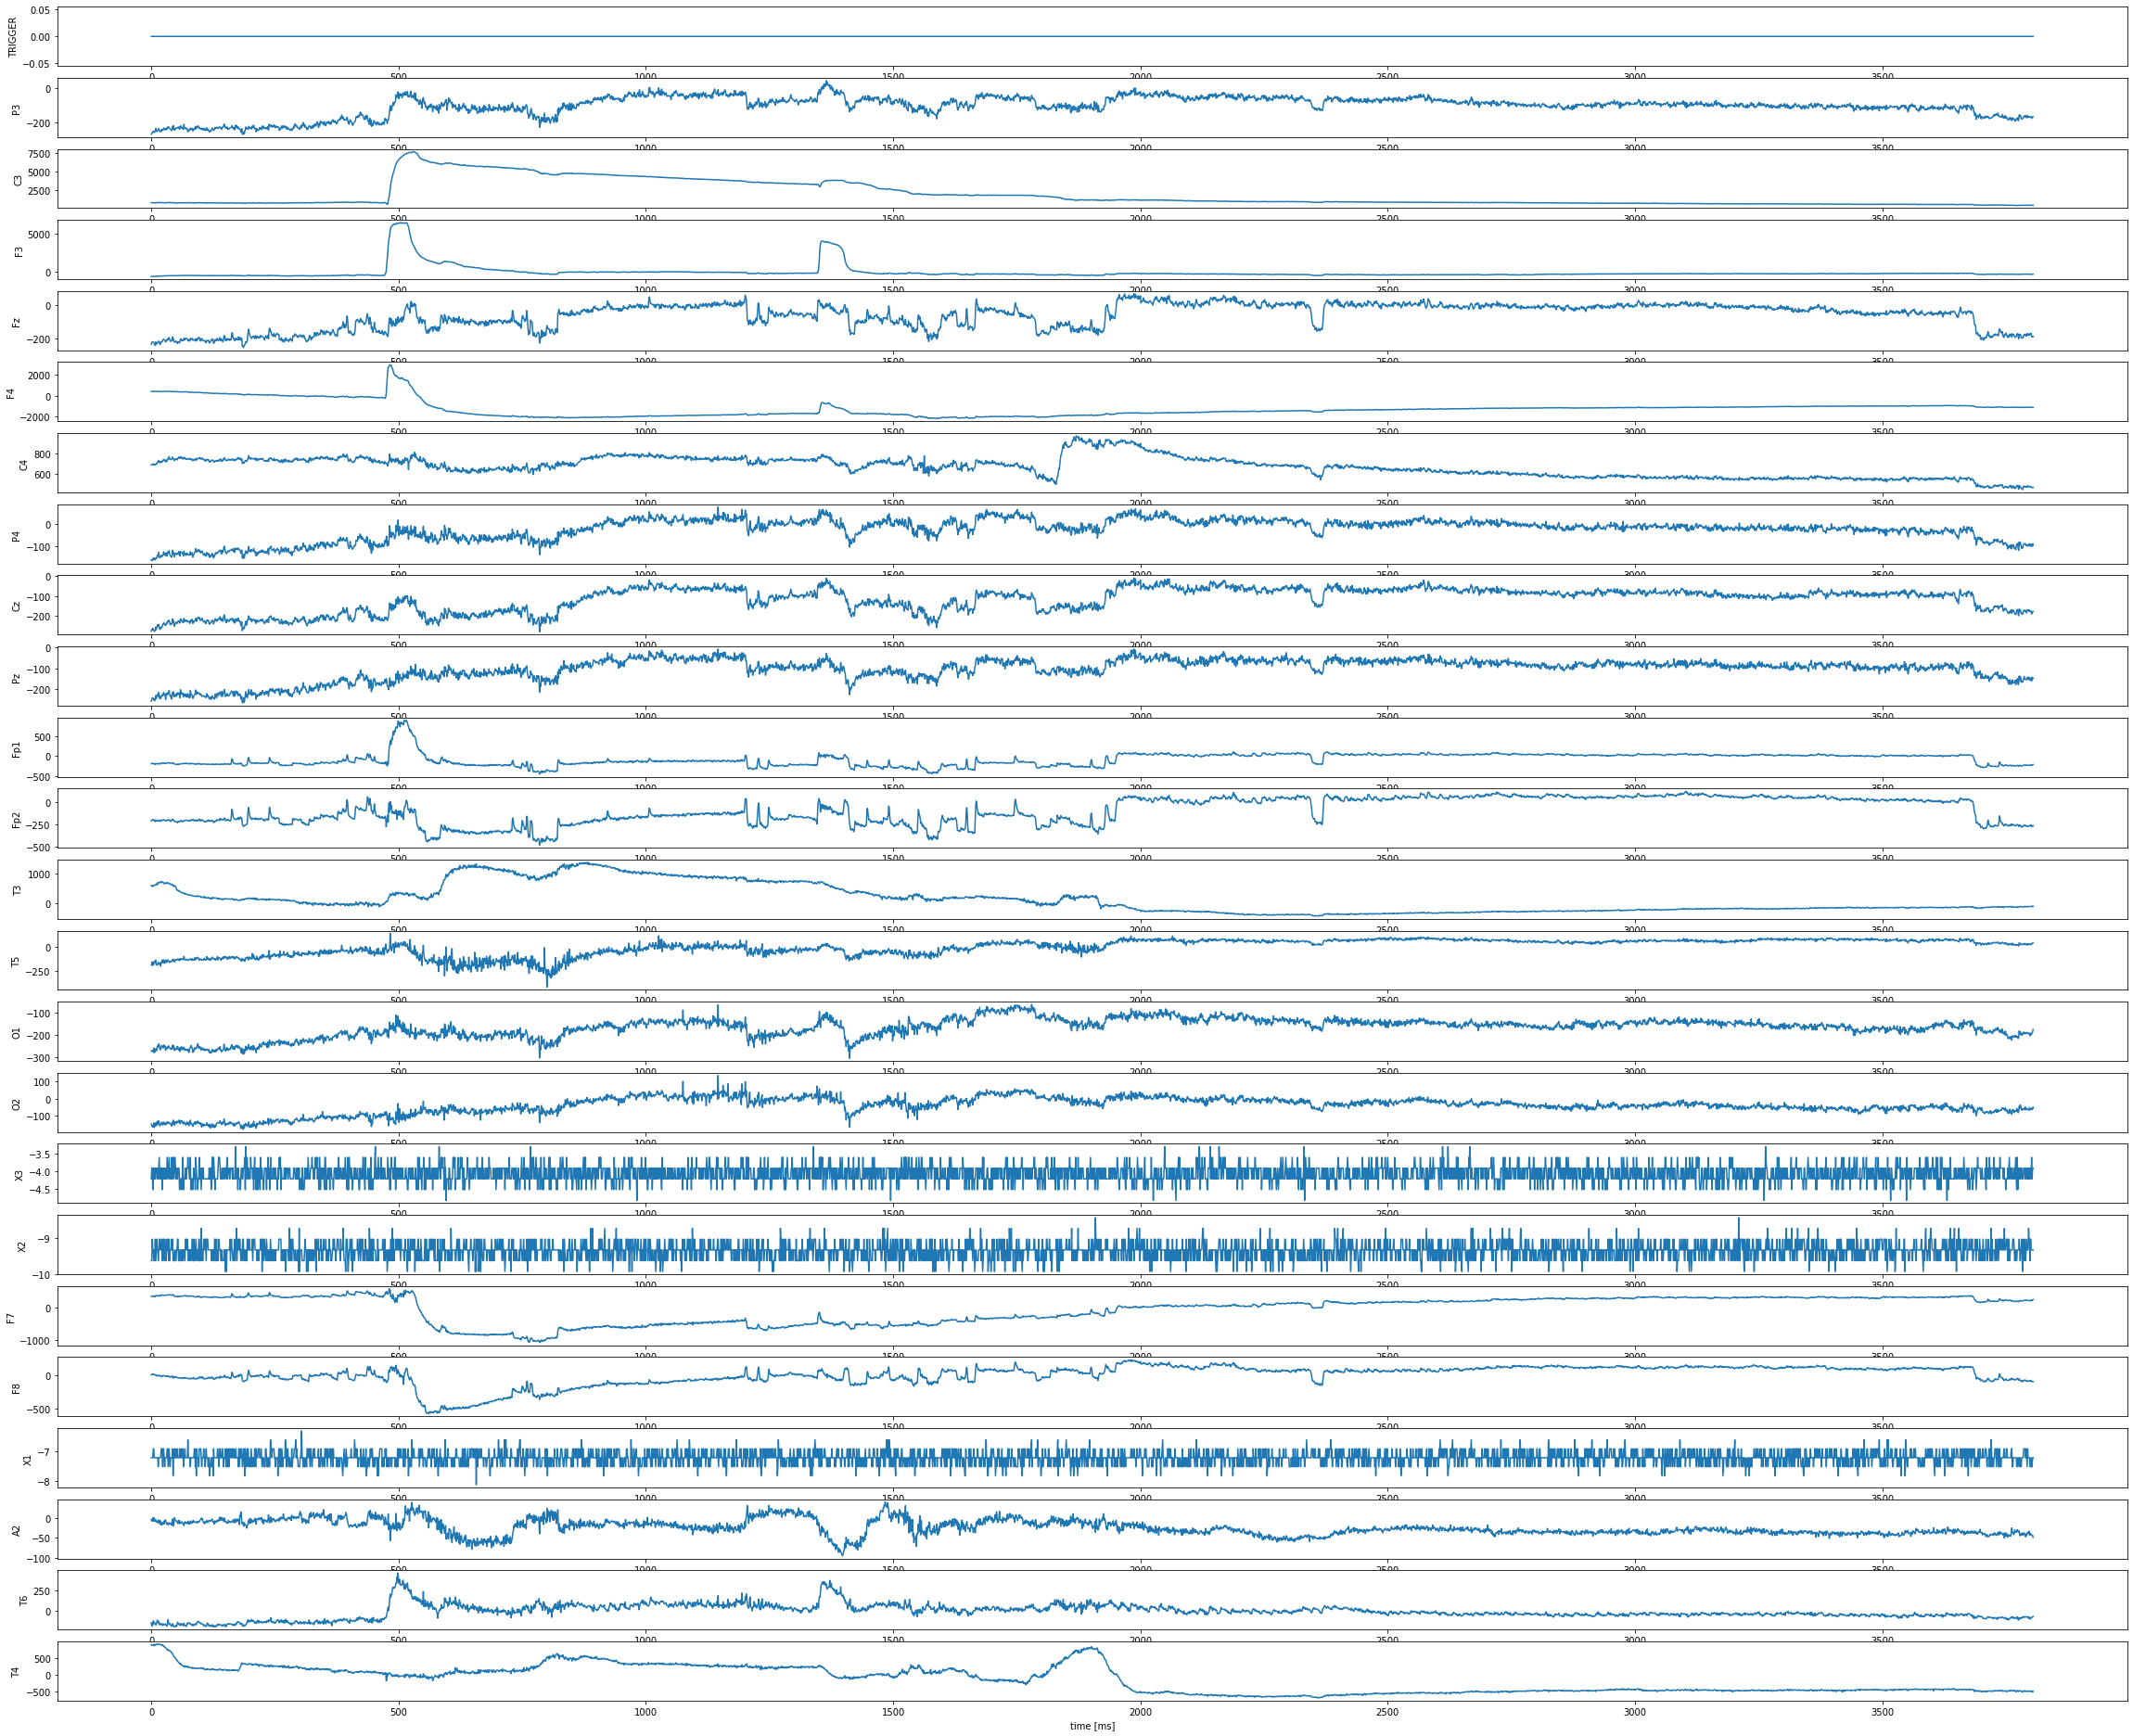

In [36]:
signals = baseline['signals']
fig, axs = plt.subplots(nrows=signals.shape[1], figsize=(40, 1.4 * signals.shape[1]))
for channel in range(signals.shape[1]):
    sns.lineplot(data=signals[::10, channel], ax=axs[channel], )
    axs[channel].set_ylabel(baseline['ch_names'][channel])
    
axs[-1].set_xlabel('time [ms]');

In [31]:
38052/60

634.2